In [209]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as sc
import seaborn as sns
import itertools
import time
import warnings


from Moment_calculation import K, calculate_D, calculate_A_a_b, first_moment, second_moment, third_moment, Pearson_approx


from scipy.integrate import quad, tplquad, dblquad, simpson, romb
from scipy.stats import norm, expon, pearson3, uniform, laplace, gamma, shapiro, t, anderson
from scipy.special import psi, polygamma
from scipy.optimize import minimize
from tqdm import tqdm

Cramer-von Mises statistics
$$n\int (\widehat{F_n}(x) - F_{\widehat{\theta}}(x))^2\, d F_{\widehat{\theta}}(x) = \\ n\sum_{i = 0}^{n} \left( \frac{i^2}{n^2}(F_{\widehat{\theta}}(X_{(i+1)}) - F_{\widehat{\theta}}(X_{(i)})) - \frac{i}{n}(F_{\widehat{\theta}}^2(X_{(i+1)}) - F_{\widehat{\theta}}^2(X_{(i)})) + \frac{1}{3} (F_{\widehat{\theta}}^3(X_{(i+1)}) - F_{\widehat{\theta}}^3(X_{(i)}))\right).$$
Anderson-Darling statistics
$$n\int (\widehat{F_n}(x) - F_{\widehat{\theta}}(x))^2\frac{1}{F_{\widehat{\theta}}(x) ( 1 - F_{\widehat{\theta}}(x))}\, d F_{\widehat{\theta}}(x) =$$
$$ = - n - \sum_{k=1}^{n}\frac{2k-1}{n}(\ln{F_{\widehat{\theta}}(X_{(k)})}+\ln{(1-F_{\widehat{\theta}}(X_{(n-k+1)}))})$$

In [211]:
def stat_CM(Y, CDF = None):
    '''
    Compute Cramer-von Mises statistics of the sample with given CDF

    Input:
        Y - sample of random variables,
        CDF - estimated distribution function.
    Output:
        Cramer-von Mises statistics
    '''
    if CDF == None:
        CDF = lambda x: norm.cdf(x, loc = np.mean(Y), scale = np.std(Y))
    n_Y = len(Y)
    Y.sort()
    # Calculate F(Y_(i))
    CDF_Y = np.apply_along_axis(CDF, axis=0, arr=Y)
    # Append 0 and 1 to series
    CDF_Y = np.concatenate([[0.0], CDF_Y, [1.0]])
    # Create points of growth of Empirical Distribution Function
    EDF_Y = np.arange(0, len(Y)+1, 1)/len(Y)
    # Calculate statistics
    with warnings.catch_warnings(action="ignore"):
        Result = np.sum(
            EDF_Y**2 * np.diff(CDF_Y) 
            - EDF_Y * np.diff(CDF_Y**2)
            + np.diff(CDF_Y**3)/3 
        )
    return Result*n_Y

def stat_AD(Y,CDF = None):
    '''
    Compute Anderson-Darling statistics of the sample with given CDF
    
    Input:
        Y - sample of random variable,
        CDF - estimated distribution function
    Output:
        Anderson-Darling statistics
    '''
    if CDF == None:
        CDF = lambda x: norm.cdf(x, loc = np.mean(Y), scale = np.std(Y))
    n_Y = len(Y)
    Y.sort()
    # Calculate F(Y_(i)) 
    CDF_Y = np.apply_along_axis(CDF, axis=0, arr=Y)
    # Create array with coefficient in statistics
    coef = (2*np.arange(1, n_Y + 1) - 1)/n_Y
    with warnings.catch_warnings(action="ignore"):
        CDF_Y = np.array(CDF_Y)
        elements_of_sum =np.log(CDF_Y)
        inv_elements_of_sum = np.log(1 - np.flip(CDF_Y))
        Result = -n_Y - sum(coef * (elements_of_sum
                                    + inv_elements_of_sum))
    return Result

# Finding moments

Hypothesis is that $X_i \sim F_{a,b}(x)$, where $F_{a,b}$ belongs to location-scale distribution family. 
Parameter $a$ is location parameter, $b$ is scale parameter. $F_0$ and $f_0$ will be CDF and PDF of distribution with parameters $a=0,b=1$ from location-scale distribution family.


Let $\widehat{\theta}$ - MLE
$$
\begin{align}
\sqrt(n)\left(\widehat{F}_n(x)  - F_{\widehat{\theta}}(x)\right) \xrightarrow[n \to \infty]{d} W_{F_{a,b}(x)}^0 - \frac{\partial}{\partial a} F_{a,b}(x) U_1 - \frac{\partial}{\partial b} F_{a,b}(x) U_1=: Y_{F_{a,b}(x)},
\end{align}\tag{1}
$$
where 
$$U_1 \sim \int\limits_0^1 g_1(F_{a,b}^{-1}(x))\, dW_x^0,$$
$$U_2 \sim \int\limits_0^1 g_2(F_{a,b}^{-1}(x))\, dW_x^0 $$
$$g(x) = \left(\frac{\partial}{\partial a} \ln f_{a,b}(x), \frac{\partial}{\partial b} \ln f_{a,b}(x)\right) \mathcal{I}(a,b)^{-1} ,$$
where $\mathcal{I}$ -- Fisher's information matrix. This representation comes from the asymptotic efficiency of MLE and from 
$$
\widehat{F}_n(x) -  F_{\widehat{\theta}}(x) = \widehat{F}_n(x) - F_{\theta}(x) + F_{\theta}(x) - F_{\widehat{\theta}}(x) =$$
$$= \widehat{F}_n(x) - F_{\theta}(x) - \frac{\partial}{\partial \theta} F_{\theta}(x) (\widehat{\theta}-\theta) + o(\widehat{\theta} - \theta).$$

Hence, covariance function of $K(t,s)$ of limit process can be represented as 
$$K(t,s) = \operatorname{cov}(Y_t, Y_s) = \operatorname{cov}(W_t^0, W_s^0)  + f_0\left(F_0^{-1}(s)\right) A_a(t) +f_0\left(F_0^{-1}(s)\right)F_0^{-1}(s) A_b(t) +$$
$$ + f_0\left(F_0^{-1}(t)\right) A_a(s) +
f_0\left(F_0^{-1}(t)\right)  f_0\left(F_0^{-1}(s)\right) D_a +$$
$$+ f_0\left(F_0^{-1}(t)\right)  f_0\left(F_0^{-1}(s)\right)F_0^{-1}(s) A_{a,b} + f_0\left(F_0^{-1}(t)\right)F_0^{-1}(t) A_b(s) +$$
$$+f_0\left(F_0^{-1}(t)\right)F_0^{-1}(t) f_0\left(F_0^{-1}(s)\right) A_{a,b} + f_0\left(F_0^{-1}(t)\right)F_0^{-1}(t) f_0\left(F_0^{-1}(s)\right)F_0^{-1}(s) D_b,$$
$$A_a(t) =  \left( \int\limits_{- \infty}^{F_0^{-1}(t)} h_1(q)  f_0(q)\,dq  - t \int\limits_{\mathbb{R}} h_1(q)  f_0(q)\,dq  \right),$$
$$A_b(t) =  \left( \int\limits_{- \infty}^{F_0^{-1}(t)} h_2(q)  f_0(q)\,dq  - t \int\limits_{\mathbb{R}} h_2(q)  f_0(q)\,dq  \right),$$
$$D_a = \left( \int\limits_{\mathbb{R}} h_1(q)^2  f_0(q)\,dq  - \left(\int\limits_{\mathbb{R}} h_1(q)f_0(q)\,dq \right)^2 \right),$$
$$D_b = \left( \int\limits_{\mathbb{R}} h_2(q)^2  f_0(q)\,dq  - \left(\int\limits_{\mathbb{R}} h_2(q)f_0(q)\,dq \right)^2 \right),$$
$$A_{a,b} = \left( \int\limits_{\mathbb{R}} h_1(q) h_2(q)  f_0(q)\,dq  - \int\limits_{\mathbb{R}} h_1(q)f_0(q)\,dq  \int\limits_{\mathbb{R}} h_2(q)f_0(q)\,dq  \right),$$
Where function h is function g with parameters 0 and 1 substituted or exact form of h:
$$h_1(y) =  \frac{1}{C_1 C_3 - C_2^2} \left( C_2 + C_2y\frac{f_0'(y)}{f_0(y)} - \frac{C_3 f_0'(y)}{f_0(y)} \right);$$
$$h_2(y) =  \frac{1}{C_1 C_3 - C_2^2} \left( \frac{C_2 f_0'(y)}{f_0(y))} -  C_1 - C_1y\frac{f_0'(y)}{f_0(y)} \right),$$
where $C_1, C_2, C_3$ derived from 
$$\mathcal{I}(0,1) = \begin{pmatrix}
C_1 & C_2 \\
C_2 & C_3
\end{pmatrix}.$$
That helps to find form of $A_a(t),A_b(t)$:
$$A_a(t) = \frac{f_0(F_0^{-1}(t))}{C_1 C_3 - C_2^2} \left( C_2 F_0^{-1}(t)- C_3\right),$$
$$A_b(t) = \frac{f_0(F_0^{-1}(t))}{C_1 C_3 - C_2^2} \left( C_2 - C_1F_0^{-1}(t)\right).$$

Functionals of limit process of (1) are used to find limit distribution of Cramer-Von Mises and Anderson-Darling:

\begin{equation}
\int\limits_{\mathbb{R}} n\left(\widehat{F}_n(x)  - F_{\widehat{\theta}}(x)\right)^2\, dF_{a,b}(x) = \int\limits_0^1 n\left(\widehat{F}_n(F_{a,b}^{-1}(y))  - F_{\widehat{\theta}}(F_{a,b}^{-1}(y))\right)^2\, dy \xrightarrow[d]{n \to \infty} \int\limits_0^1 Y_t^2\,dt =: Z_{CVM}
\end{equation}\tag{2}

\begin{equation}
\int\limits_0^1 n\left(\widehat{F}_n(F_{a,b}^{-1}(y))  - F_{\widehat{\theta}}(F_{a,b}^{-1}(y))\right)^2\frac{1}{y(1-y)}\, dy \xrightarrow[d]{n \to \infty} \int\limits_0^1 Y_t^2 \frac{1}{t(1-t)}\,dt =: Z_{AD}.
\end{equation}\tag{3}

Moments of this statistics can be represented through functions of the covariance function (for Anderson-Darling $w(x)=1/(x(1-x))$ and Cramer-Von Mises $w(x)=1$):
$$\textbf{E}Z = \int\limits_0^1 K(t,t)w(t)\,dt$$
$$\textbf{E}Z^2 = 2\int\limits_0^1\int\limits_0^1 K(t,s)^2w(t)w(s)\, dt\,  ds  + \left( \int\limits_0^1 K(t,t)w(t)\, dt\right)^2$$
$$\textbf{E}Z^3 =\int\limits_0^1 \int\limits_0^1 \int\limits_0^1 ( K(t,t) (K(s,s) K(r,r) + 2K^2(s,r)) +\\
    + 2 K(t,s)(K(t,s)K(r,r) +
    2 K(t,r) K(s,r))+\\+ 2K(t,r)(K(t,r)K(s,s) + 2K(t,s)K(s,r))) w(t)w(s)w(r)\, dt\,ds\,dr$$

## Normal distribution hypothesis

In [28]:
# Statistics. If you need find limit distribution
# of Anderson-Darling statistics -> True
# of Cramer-Von Mises -> False
Anderson_Darling=False

# Input information
# funtions h_1, h_2
h = [(lambda x: x), 
     (lambda x: 0.5*(x*x - 1))]

distr = norm
# If this values are unkown then use functions 
# Calculate_D, Calculate_A_a_b
D_a = 1
D_b = 0.5
A_a_b = 0
# Elements of Information matrix
C_1, C_2, C_3 = 1, 0, 2

In [29]:
# Creating funtions A_a and A_b
A_a = lambda x: 1/(C_1*C_3 - C_2*C_2) * (C_2*distr.ppf(x) - C_3)
A_b = lambda x: 1/(C_1*C_3 - C_2*C_2) * (C_2 - C_1*distr.ppf(x))
K_t_s = lambda t,s: K(t, s, A_a, A_b, D_a, D_b, A_a_b, distr)

In [30]:
# finding moments
## FIRST MOMENT
print("Finding first moment -- start")
start = time.time()
EY_1, err = first_moment(K_t_s, Anderson_Darling=Anderson_Darling)
end = time.time()
print(f"First moment:\n\t equals = {EY_1}\n\t error = {err}")
print(f"Finding first moment -- finish | time={end-start} s.")


## SECOND MOMENT
print("Finding second moment -- start")
start = time.time()
EY_2, err = second_moment(K_t_s, Anderson_Darling=Anderson_Darling, epsabs=1e-4)
end = time.time()
print(f"Second moment:\n\t equals = {EY_2}\n\t error = {err}")
print(f"Finding second moment -- finish | time={end-start} s.")

Finding first moment -- start
First moment:
	 equals = 0.0594638258914265
	 error = 7.315570826414845e-09
Finding first moment -- finish | time=1.1468827724456787 s.
Finding second moment -- start
Second moment:
	 equals = 0.004703325148254459
	 error = 9.240102131820993e-05
Finding second moment -- finish | time=29.952856063842773 s.


In [31]:
## THIRD MOMENT
N = 1_000_000
M = 100
print("Finding third moment -- start")
start = time.time()
EY_3 = third_moment(K_t_s, Anderson_Darling=Anderson_Darling, M=M)
err = 1/np.sqrt(N*M)
end = time.time()
print(f"Third moment:\n\t equals = {EY_3}\n\t error = {err}")
print(f"Finding third moment -- finish | time={end-start} s.")

Finding third moment -- start


100%|██████████| 100/100 [30:09<00:00, 18.10s/it]

Third moment:
	 equals = 0.10988263154527571
	 error = 0.0001
Finding third moment -- finish | time=1809.6378450393677 s.


## Exponential distribution hypothesis

In [32]:
# Statistics. If you need find limit distribution
# of Anderson-Darling statistics -> True
# of Cramer-Von Mises -> False
Anderson_Darling=False
# Input information
# funtions h_1, h_2
h = [lambda x: 0,
     lambda x: (x-1)]
distr = expon
# If this values are unkown then use functions 
# Calculate_D, Calculate_A_a_b
D_a = 0
D_b = 1
A_a_b = 0

# This part in unimportant in exponential case
# # Elements of Information matrix
# C_1, C_2, C_3 = 1, 0, 2

In [33]:
# Creating funtions A_a and A_b
A_a = lambda x: 0
A_b = lambda x: - distr.ppf(x)
K_t_s = lambda t,s: K(t, s, A_a, A_b, D_a, D_b, A_a_b, distr)

In [34]:
# finding moments
## FIRST MOMENT
print("Finding first moment -- start")
start = time.time()
EY_1, err = first_moment(K_t_s, Anderson_Darling=Anderson_Darling)
end = time.time()
print(f"First moment:\n\t equals = {EY_1}\n\t error = {err}")
print(f"Finding first moment -- finish | time={end-start} s.")


## SECOND MOMENT
print("Finding second moment -- start")
start = time.time()
EY_2, err = second_moment(K_t_s, Anderson_Darling=Anderson_Darling, epsabs=1e-4)
end = time.time()
print(f"Second moment:\n\t equals = {EY_2}\n\t error = {err}")
print(f"Finding second moment -- finish | time={end-start} s.")

Finding first moment -- start
First moment:
	 equals = 0.0925925925931859
	 error = 3.3589319981540393e-09
Finding first moment -- finish | time=0.41894102096557617 s.
Finding second moment -- start
Second moment:
	 equals = 0.012929754508543459
	 error = 7.596812355282784e-05
Finding second moment -- finish | time=19.211615800857544 s.


In [35]:
## THIRD MOMENT
N = 1_000_000
M = 100
print("Finding third moment -- start")
start = time.time()
EY_3 = third_moment(K_t_s, Anderson_Darling=Anderson_Darling, M=M)
err = 1/np.sqrt(N*M)
end = time.time()
print(f"Third moment:\n\t equals = {EY_3}\n\t error = {err}")
print(f"Finding third moment -- finish | time={end-start} s.")

Finding third moment -- start


100%|██████████| 100/100 [24:16<00:00, 14.56s/it]

Third moment:
	 equals = 0.0026439652973682813
	 error = 0.0001
Finding third moment -- finish | time=1456.0775797367096 s.


# Saved_results

In [3]:
known_moments_AD = {
    norm: (0.3844268602979516, 
           0.18401028190936827, 
           0.10990605341084154),
    expon: (0.5958861936810326,
            0.49434301676299813,
            0.569467948252653),
}
known_moments_CVM = {
    norm: (0.059463825892370634, 
           0.004703325148254459, 
           0.0004894390351260039),
    expon: (0.0925925925931859,
            0.012930041792322152,
            0.0026435841152607355),
}

We will approximate distribution of $Z_{AD}$ AND $Z_{CVM}$ Pearson Type III distribution (Because limit process looks like integral of weighted $\chi^2$ distribution). We have $\mu_1 = \textbf{E}Z^1, mu_2 = \textbf{E}Z^2, \mu_3 = \textbf{E}Z^3$.Hence 
$$f(x; a, \tau, \eta) = \frac{1}{\tau^{\eta}\Gamma(\eta)} (x-a)^{\eta -1} \exp\left\{-\frac{x-a}{\tau} \right\},$$
Where parameters 
$$a = \mu_1 - \frac{2\sigma}{\gamma}, \quad \tau = \frac{\gamma \sigma}{2},\quad\eta = \frac{4}{\gamma^2},$$
$$\sigma^2 = \mu_2 - \mu_1^2, \quad \gamma = \frac{\mu_3 - 3 \mu_1 \sigma^2 - \mu_1^3}{\sigma^3}.$$

In [4]:
# Create dict with approximate distribution based on three moments
AD_Pearson_approx = {
    norm: Pearson_approx(*known_moments_AD[norm]),
    expon: Pearson_approx(*known_moments_AD[expon])
}
CVM_Pearson_approx = {
    norm: Pearson_approx(*known_moments_CVM[norm]),
    expon: Pearson_approx(*known_moments_CVM[expon])
}

# Graphics

Test of approximate criteria

In [268]:
from scipy.stats import t
# Sample distributions to test
sample_distribution = {
    'N(0,1)' : norm(loc=0, scale=1),
    'N(2,2)' : norm(loc=2, scale=np.sqrt(2)),
    'Exp(1)': expon(scale=1),
    'Exp(10)': expon(scale=0.1),
    't(5)': t(df=5),
    'Laplace(0,1)': laplace(loc=0, scale=1),
    'Gamma(1,1)': gamma(1, scale=1), 
    'Gamma(1.1,1)': gamma(1.1, scale=1),
}
# Tested hypothesis
hypothesis ={
    "Norm": norm,
    "Exp": expon
}

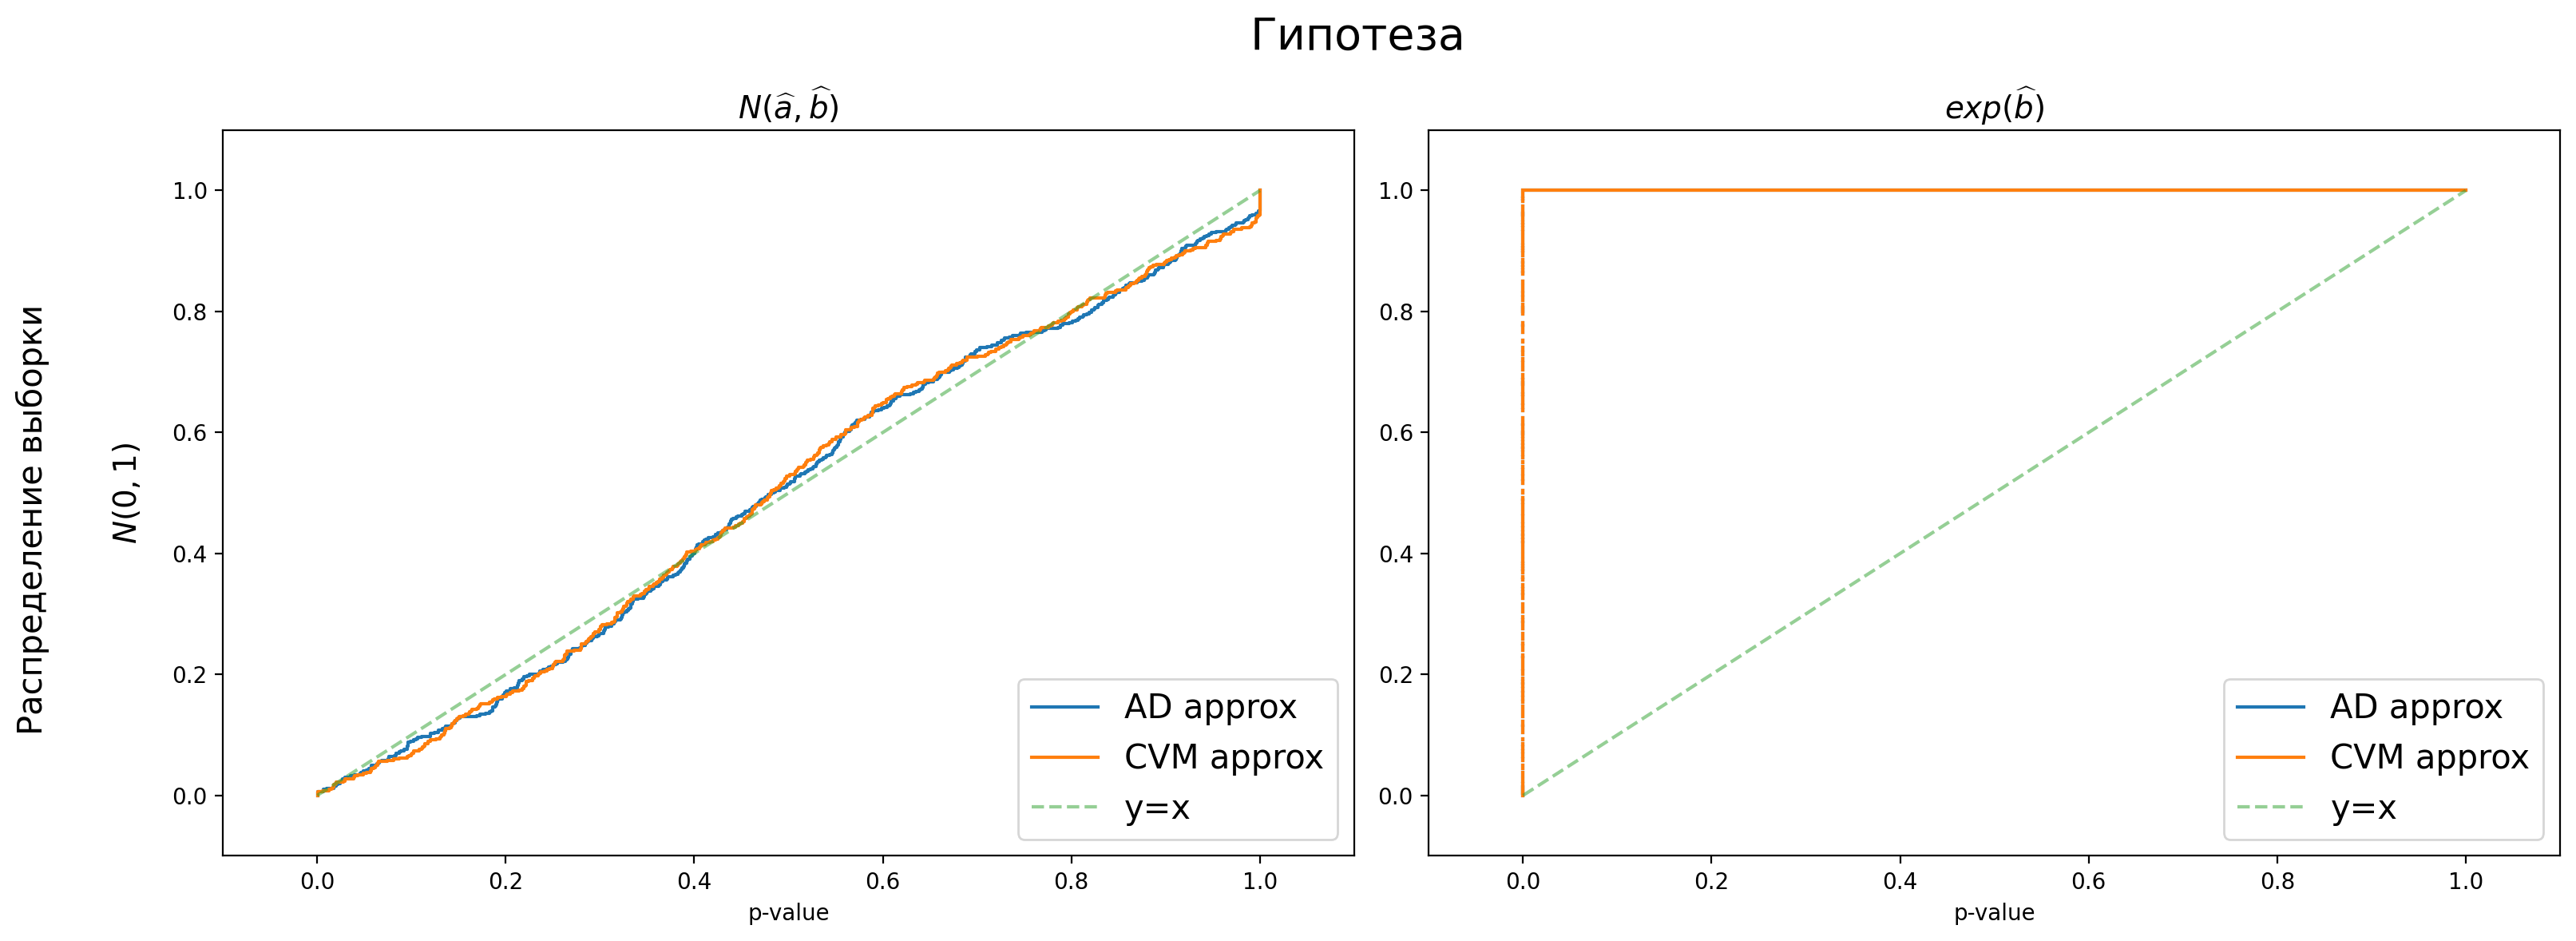

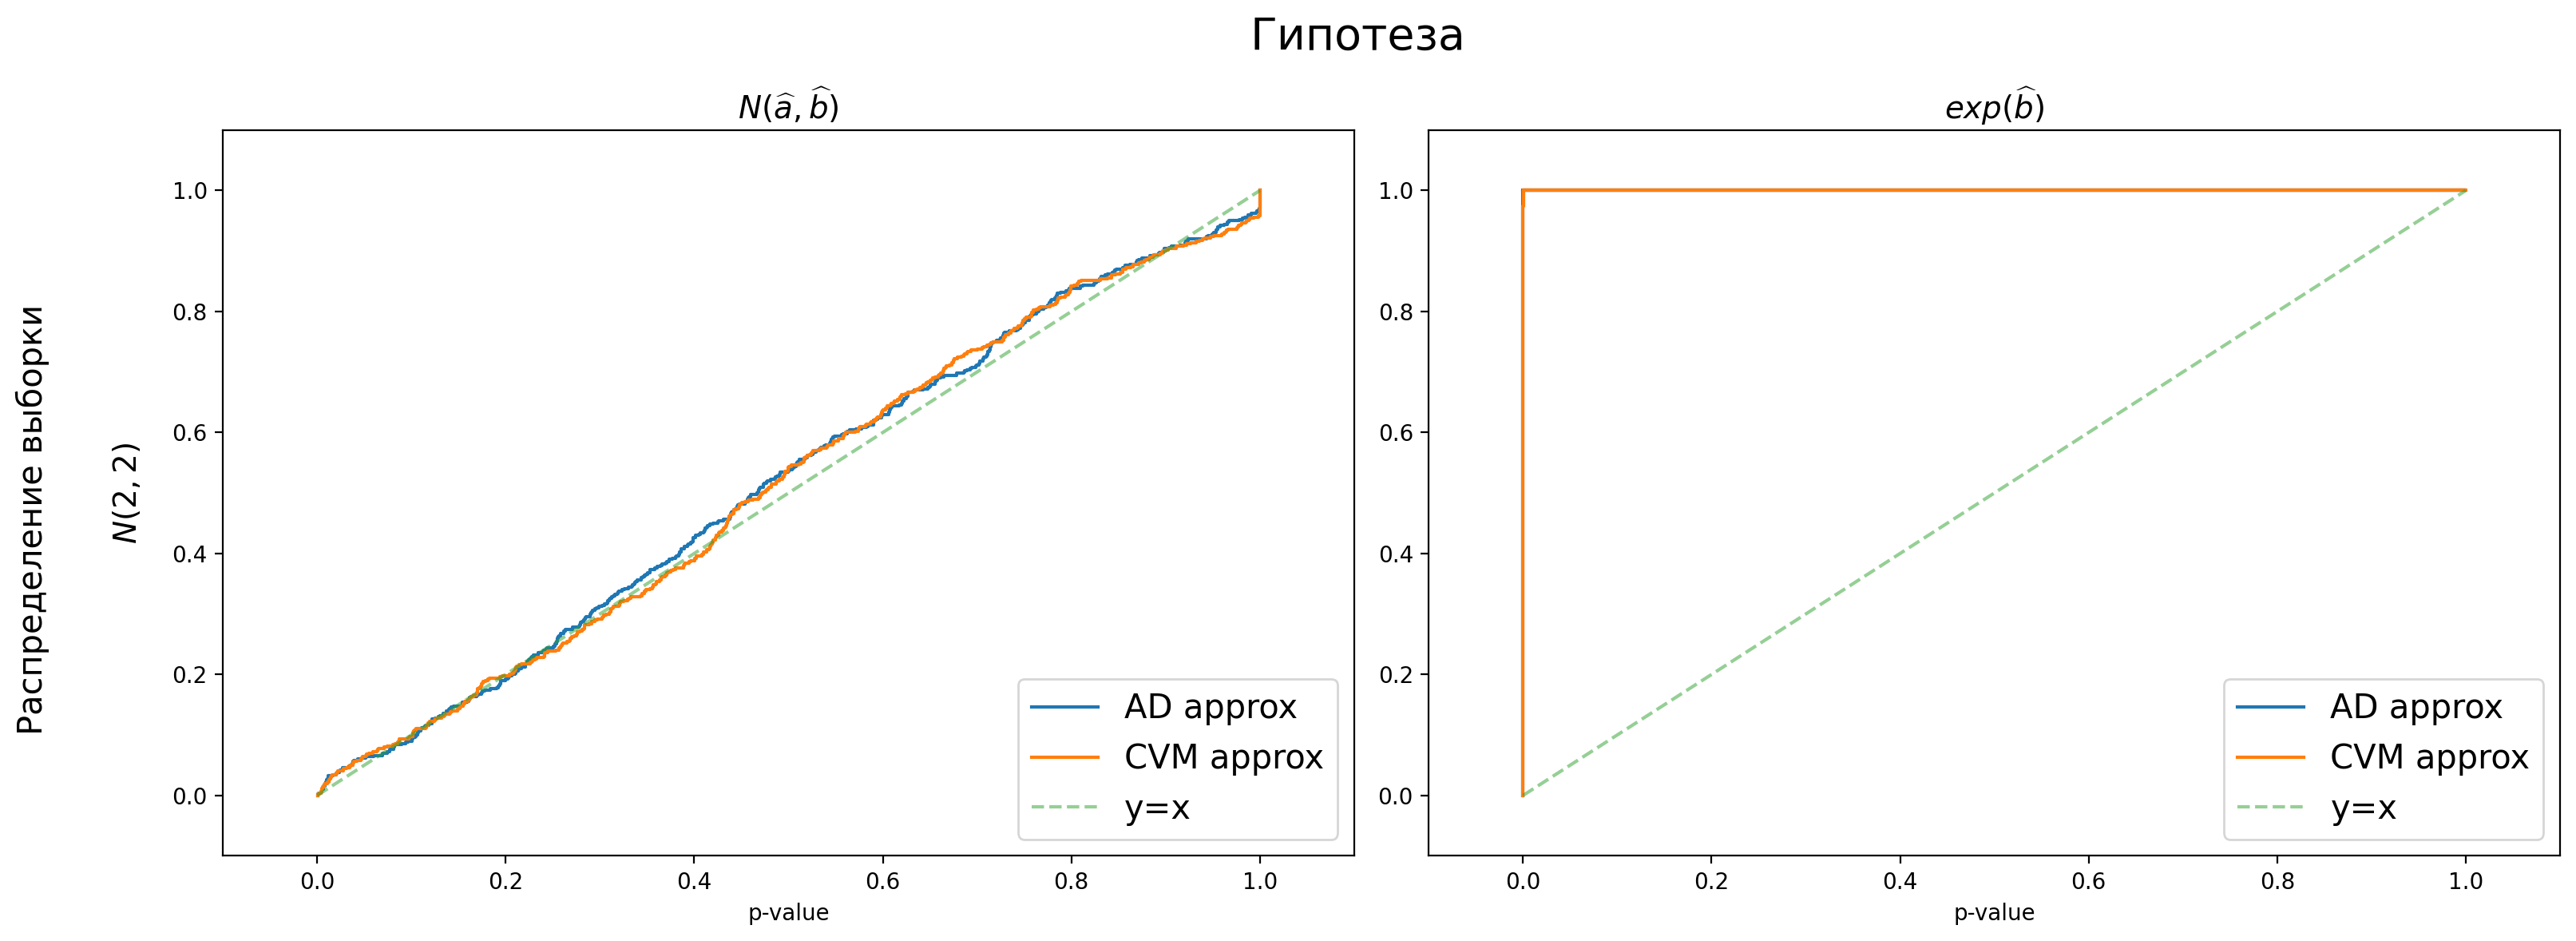

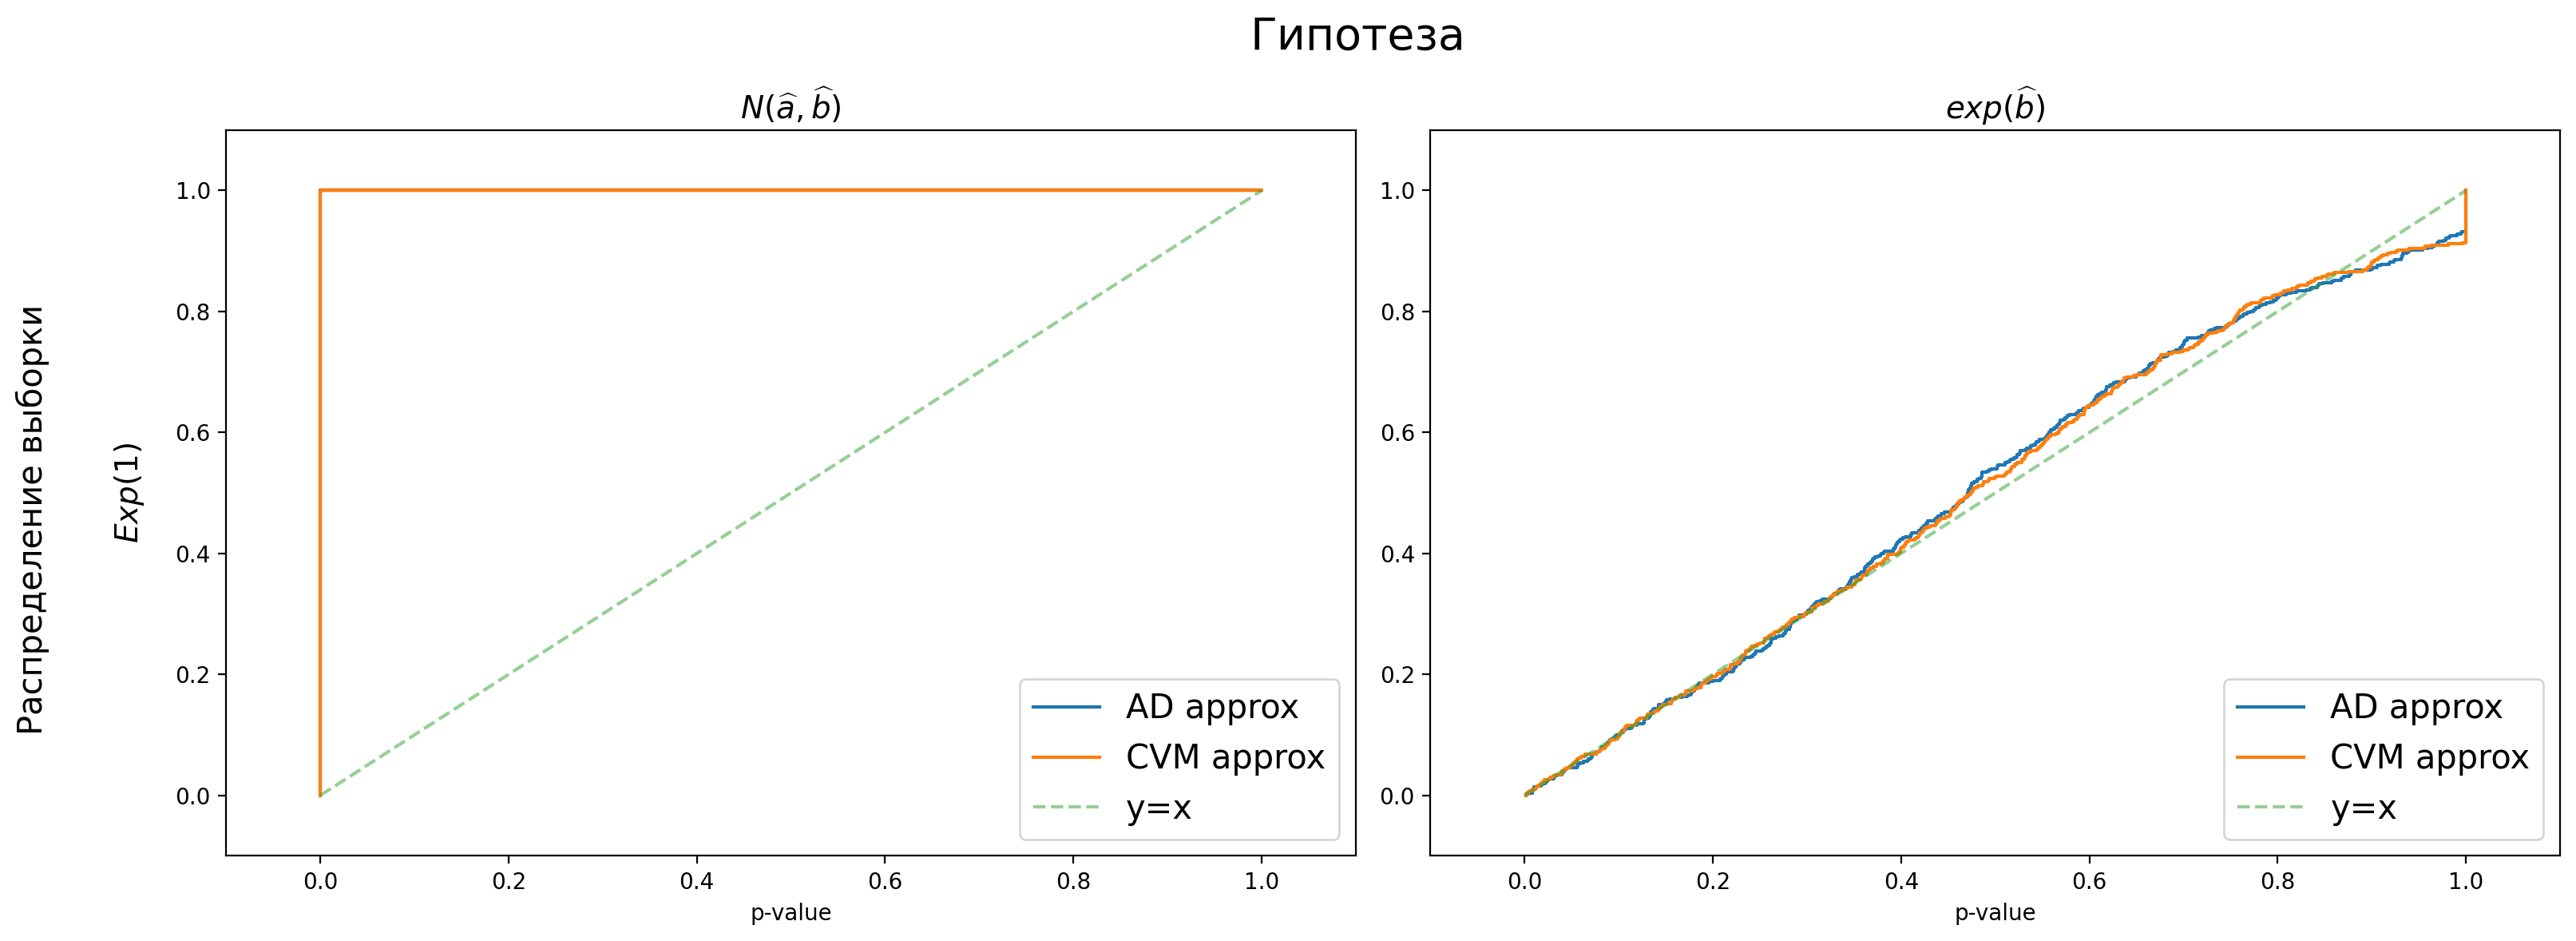

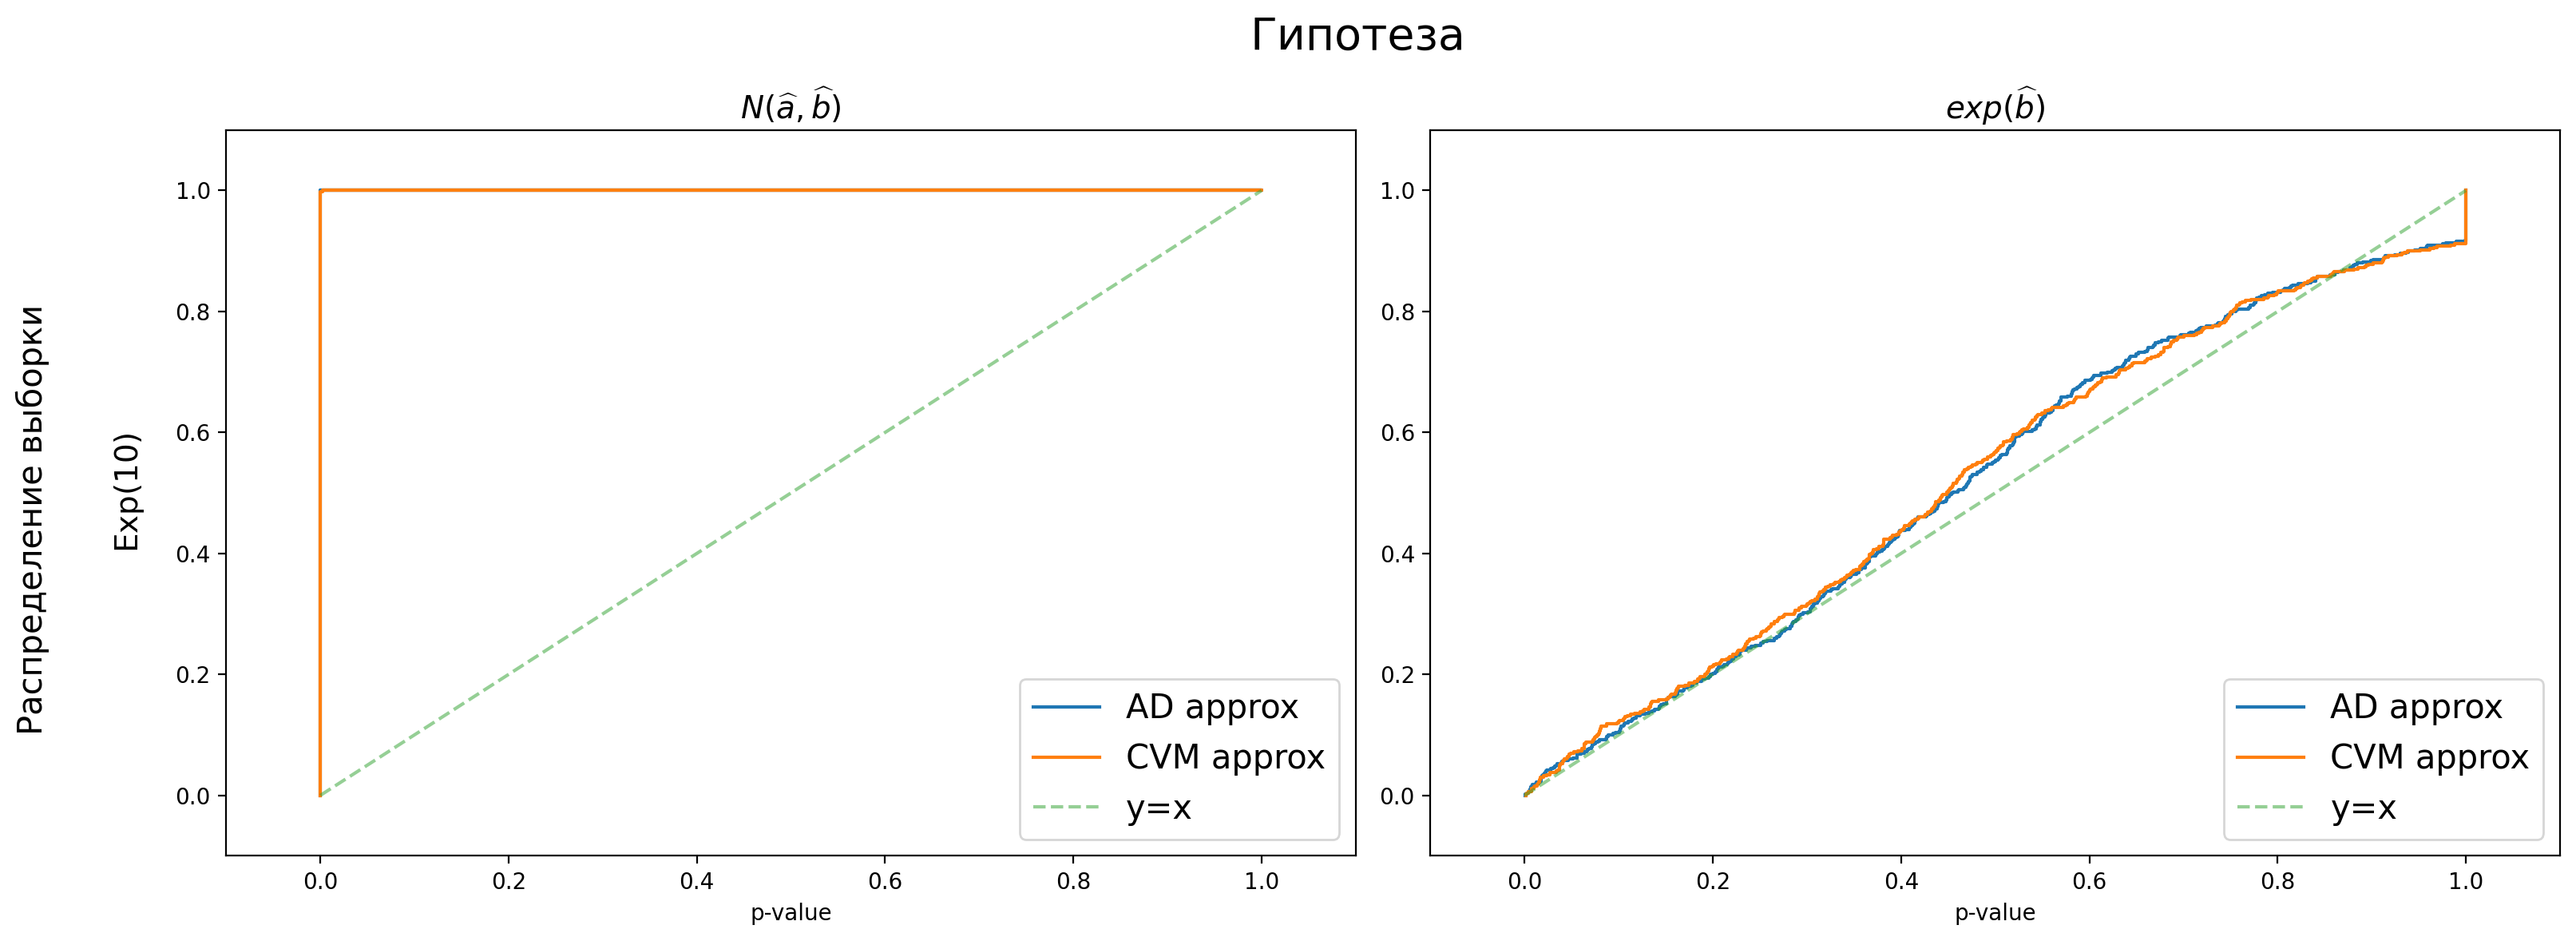

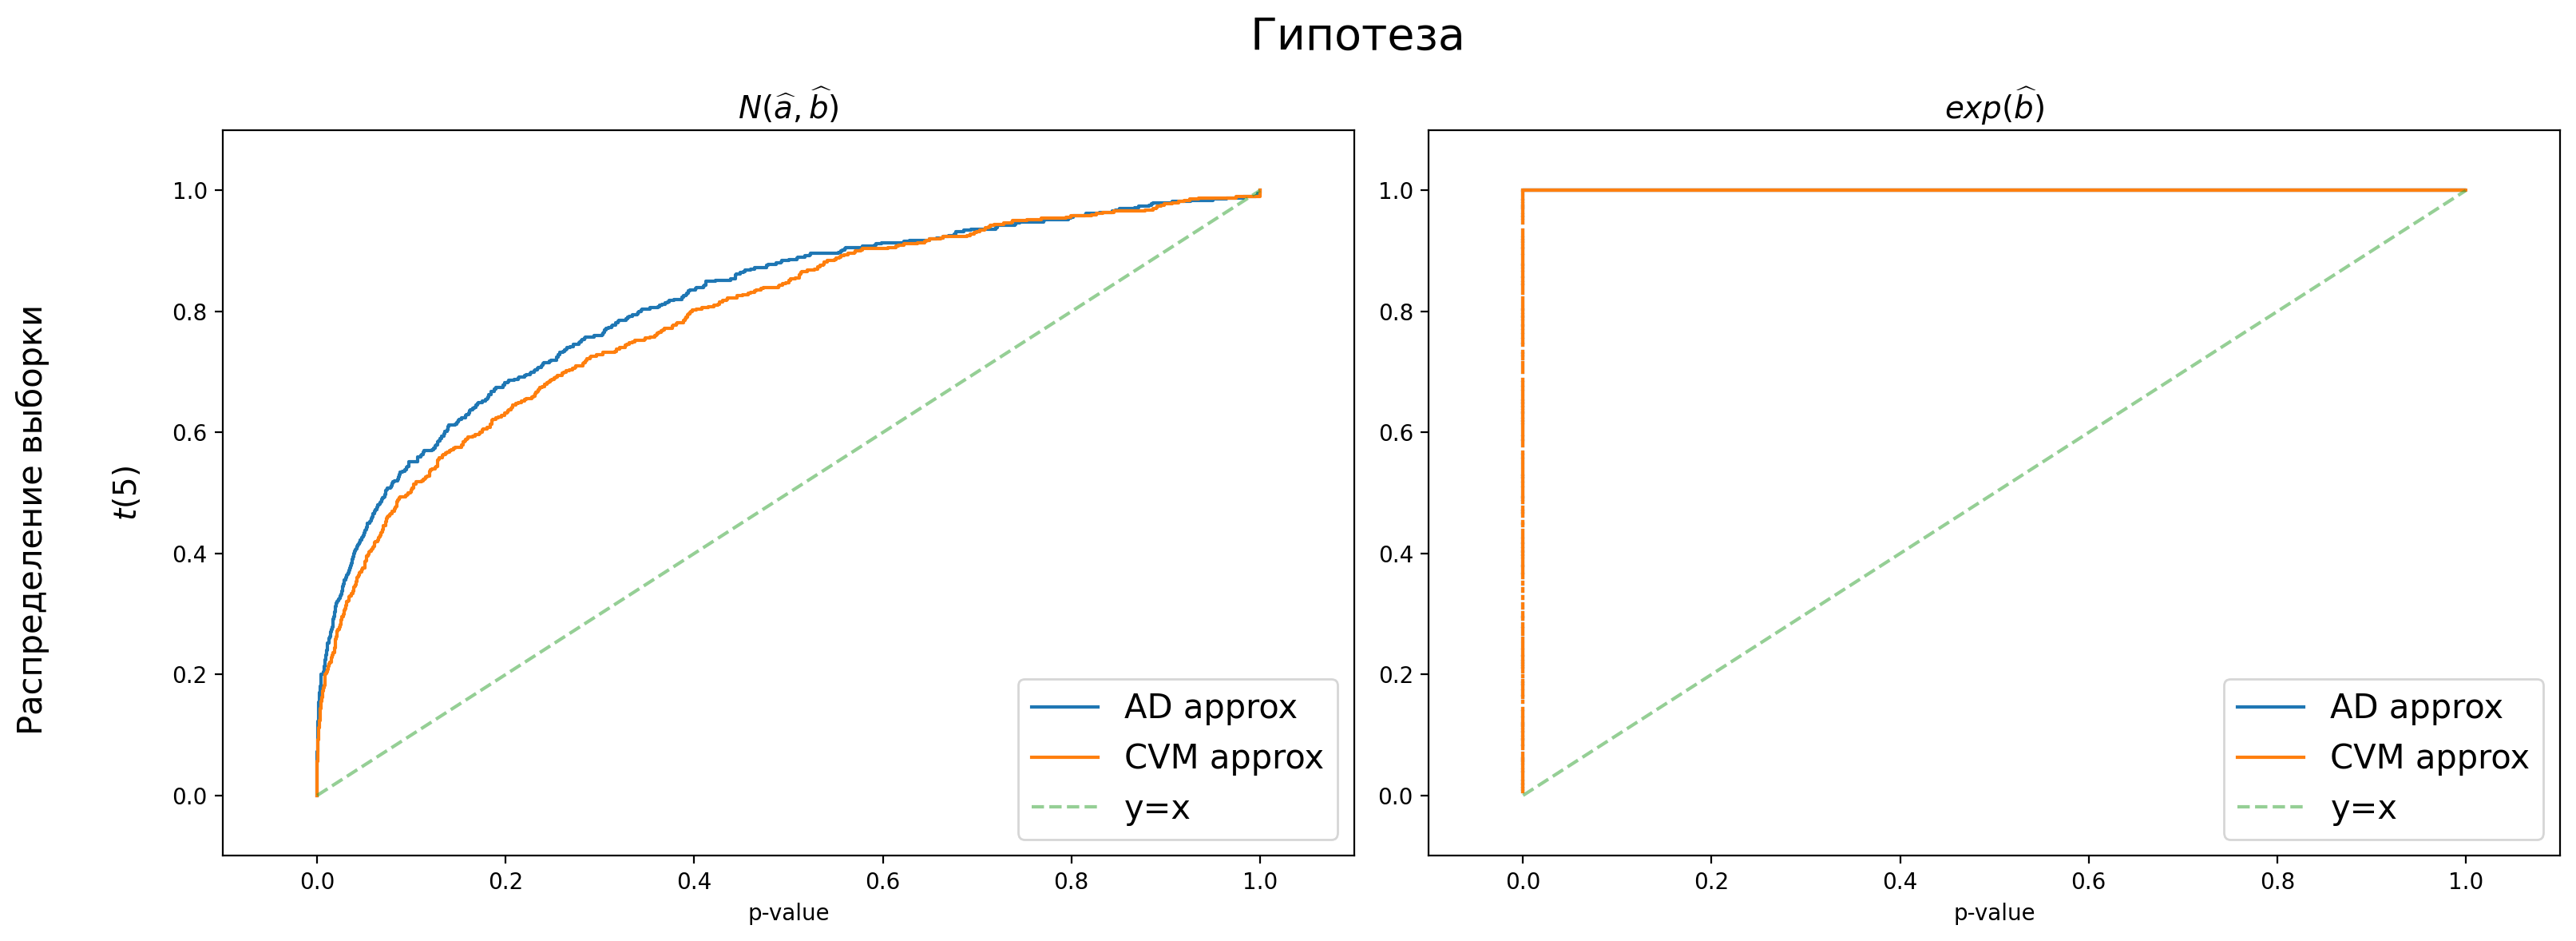

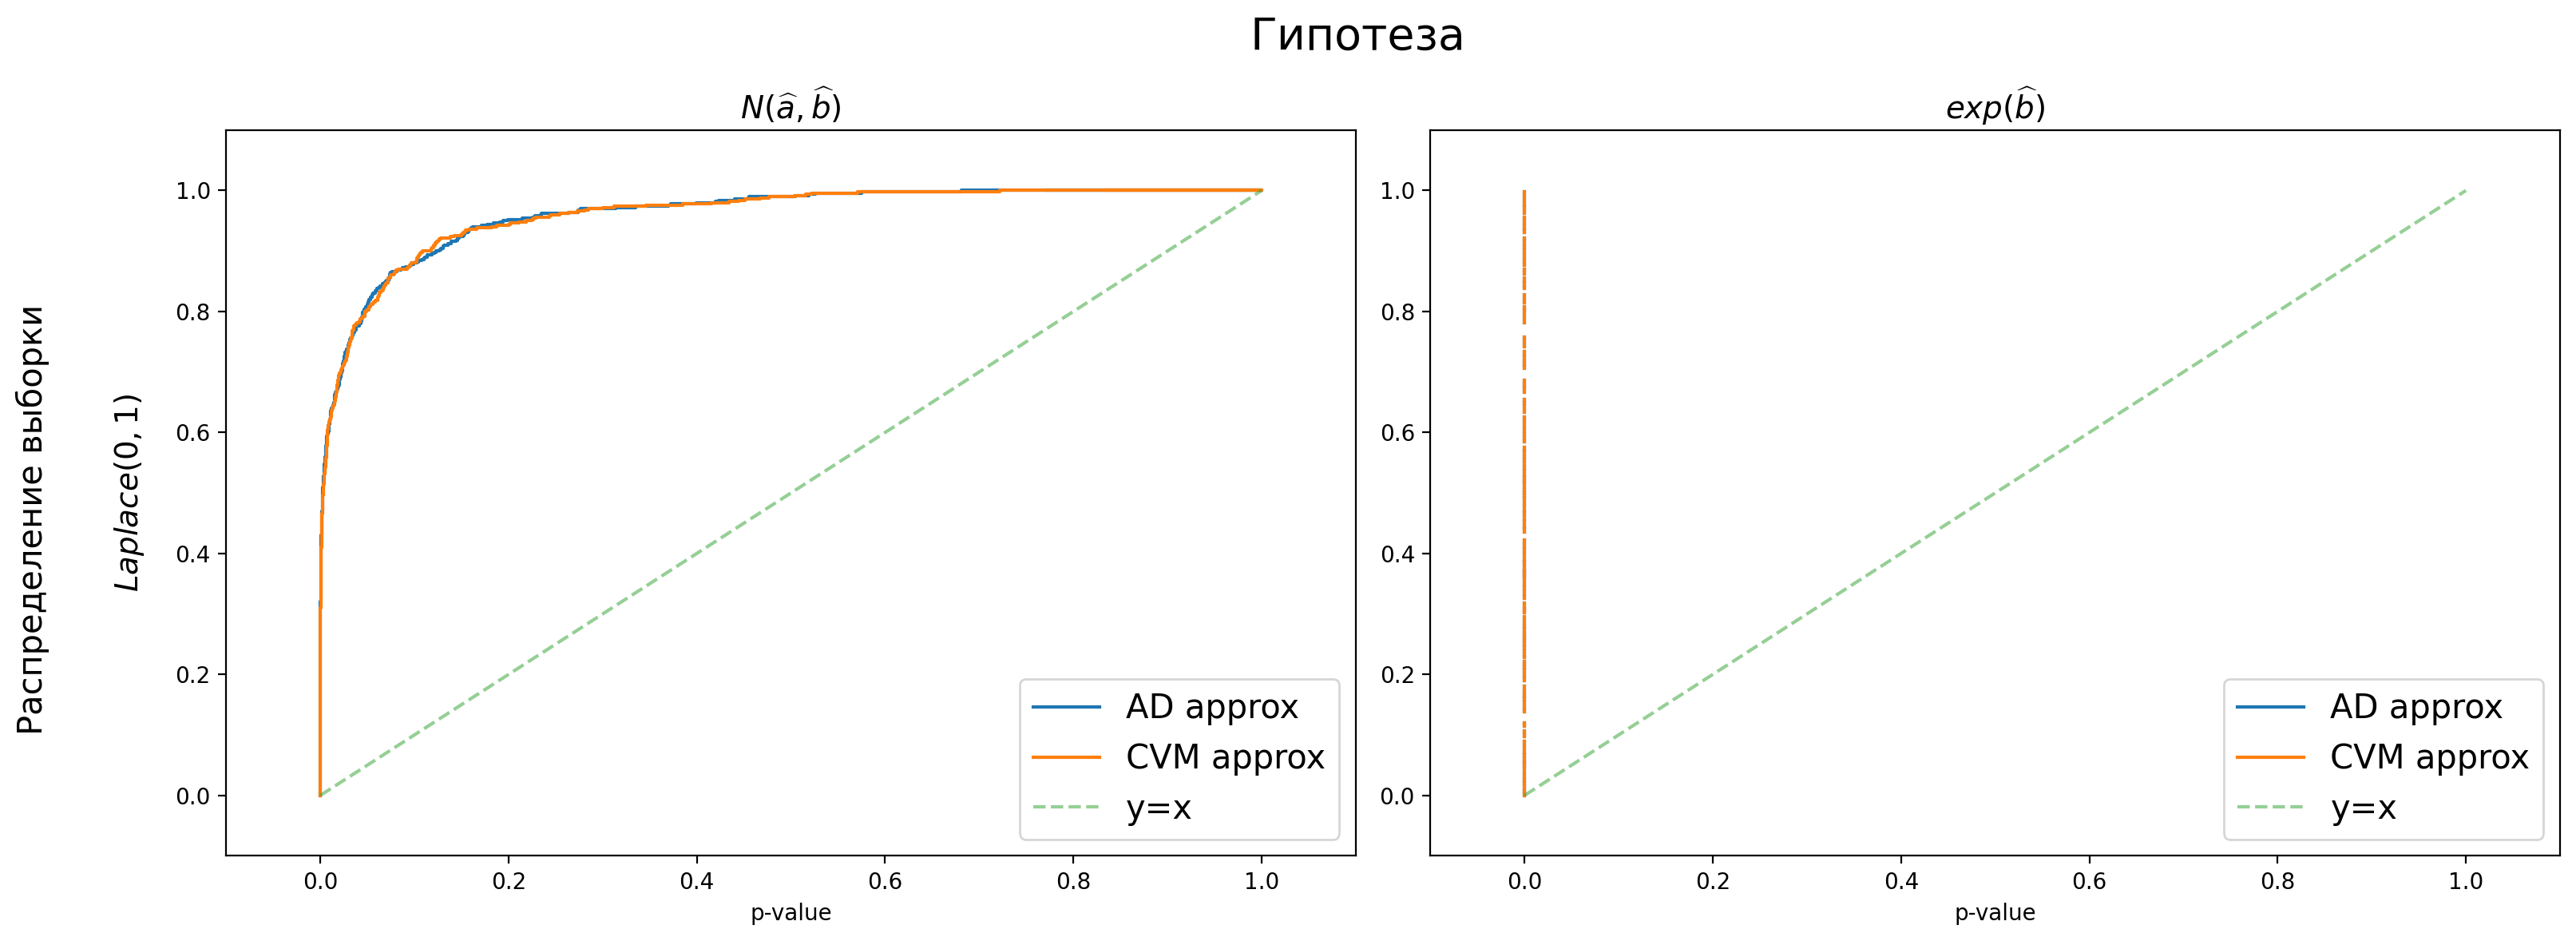

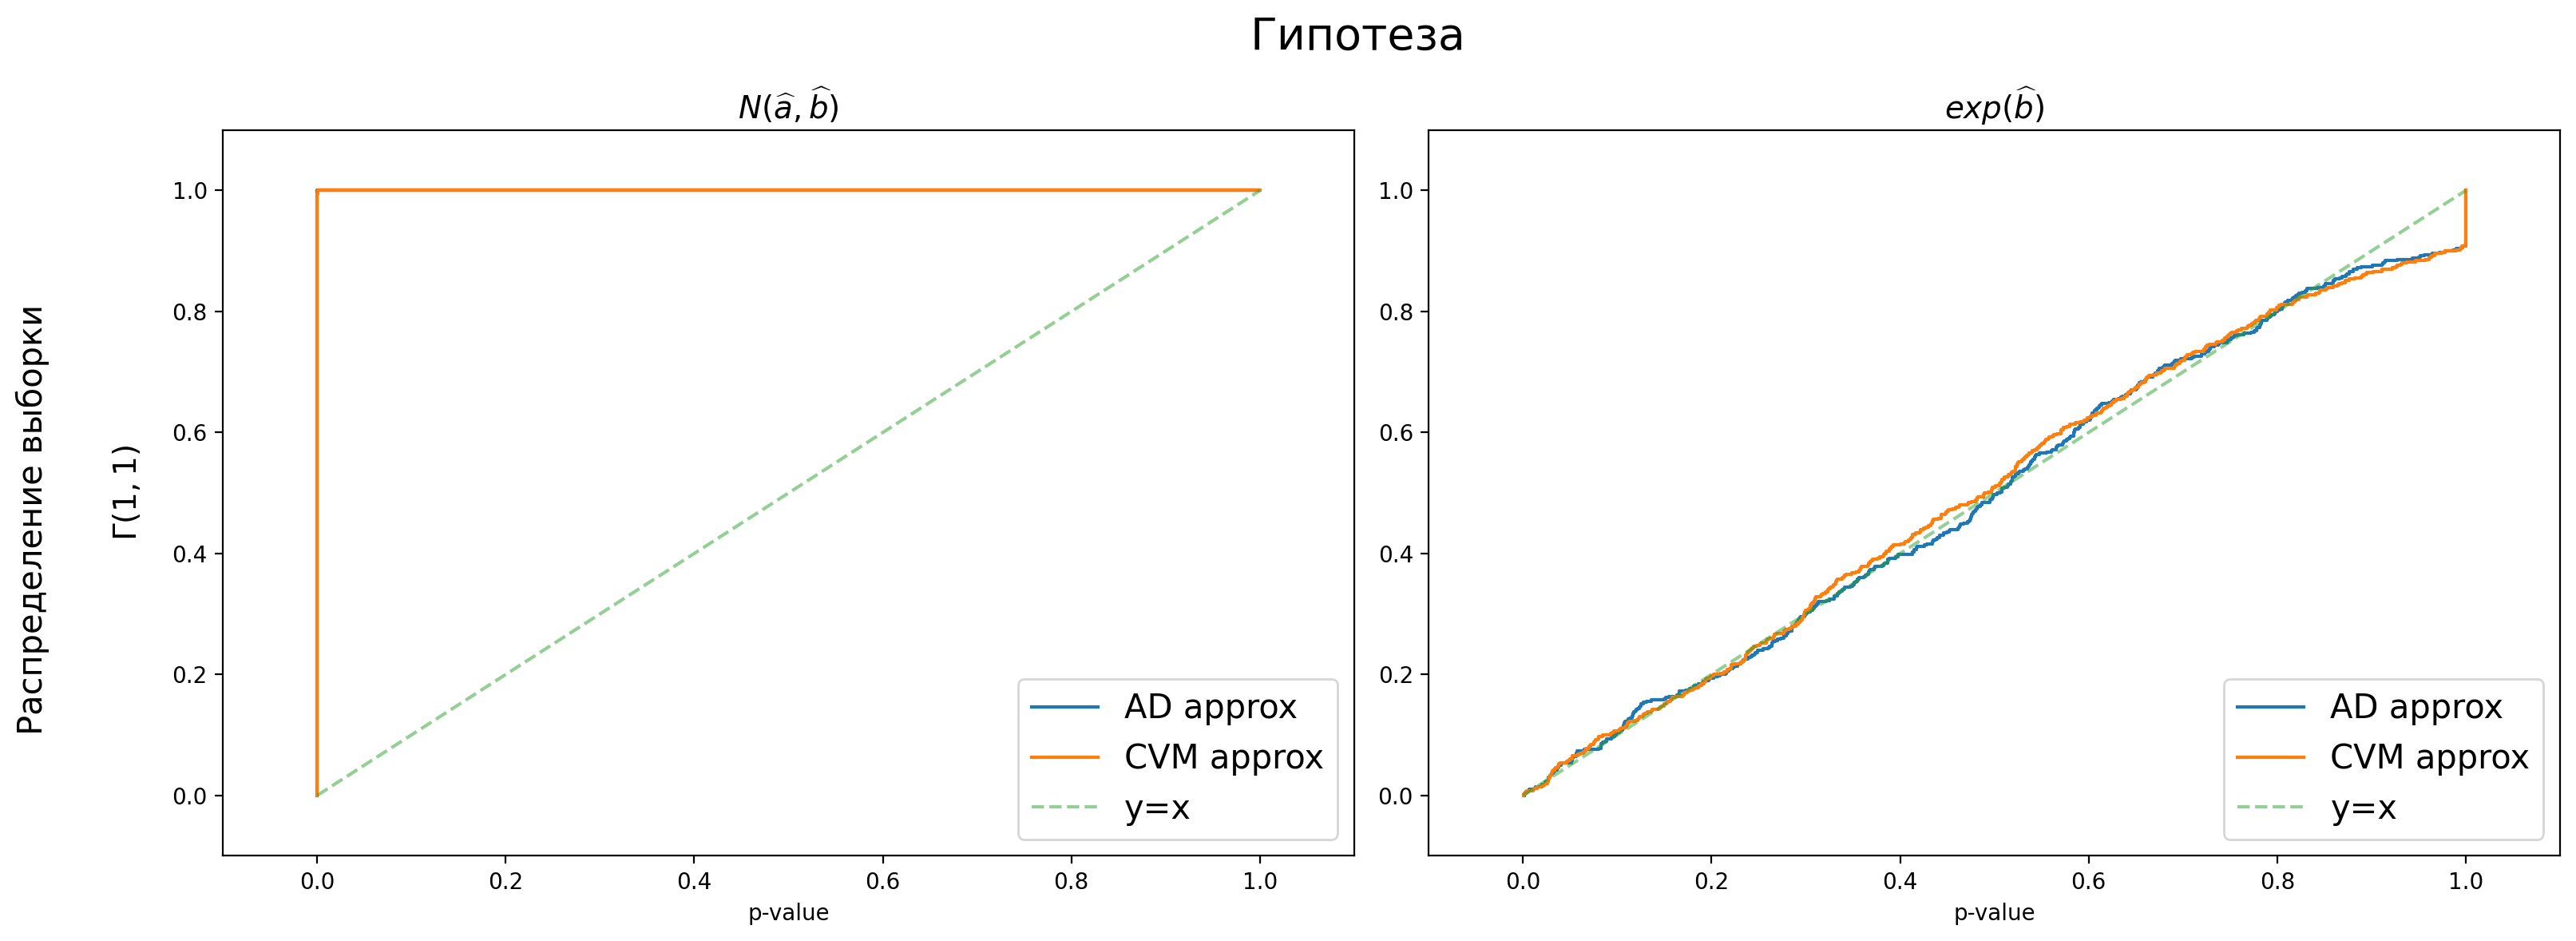

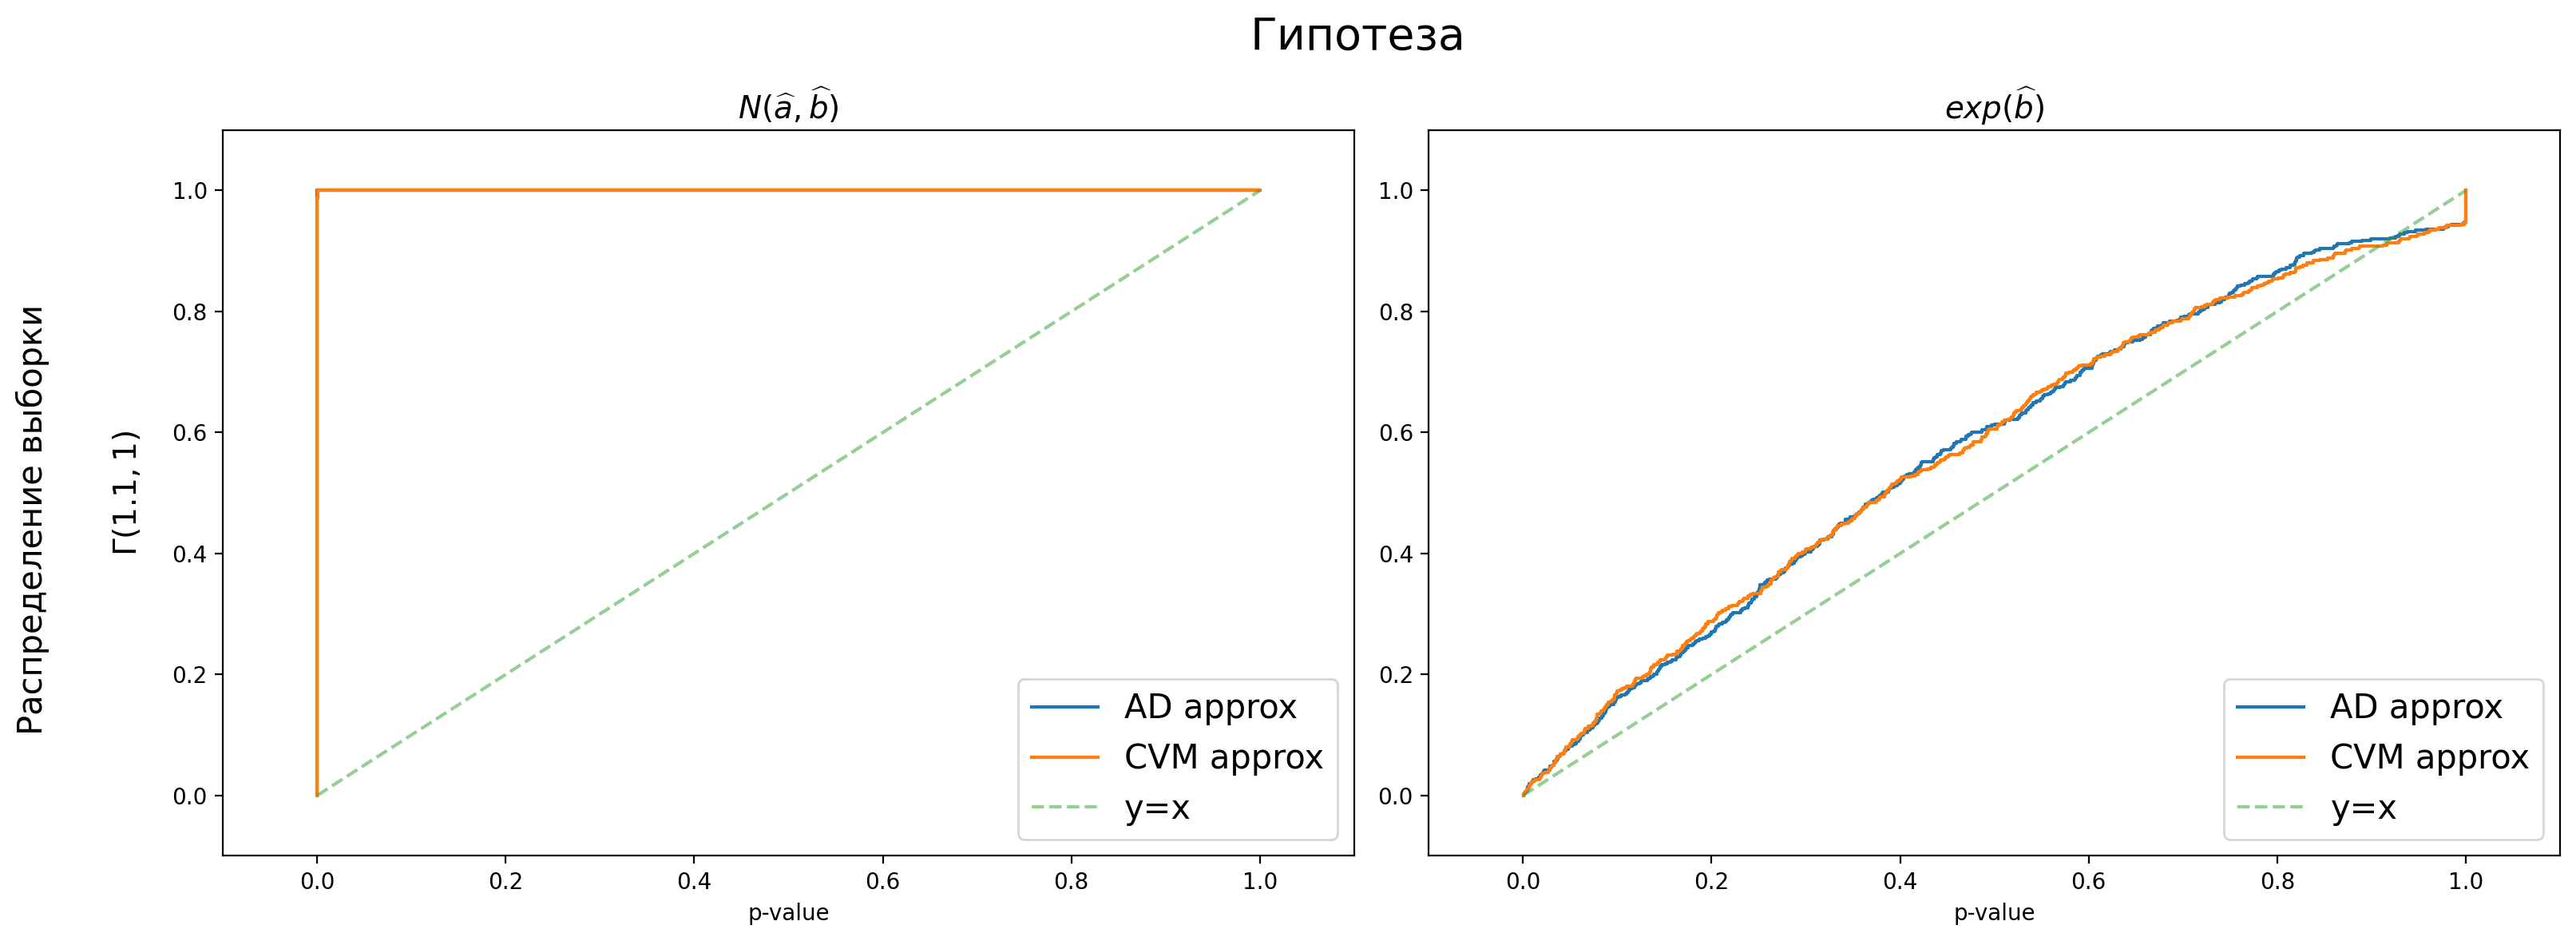

In [270]:
# Column names
cols = ['$N$($\\widehat{a},\\widehat{b}$)',
        '$exp$($\\widehat{b}$)']
# Row names
rows = ['$N$($0,1$)', '$N$($2,2$)', '$Exp$($1$)', 'Exp($10$)',
         '$t(5)$', '$Laplace$($0,1$)',
         '$\\Gamma$($1,1$)', '$\\Gamma$($1.1,1$)']
# Size of samples
SIZE = 100
# Number of samples
M = 501
# Technical value for ploting
pad = 5
ticks = np.linspace(0, 1, M, endpoint=True)
for i, (name_sample, sample_dist) in (enumerate(sample_distribution.items())):
    # Create figure for plots
    fig, axs = plt.subplots(1, len(hypothesis),
                            figsize=(len(hypothesis)*8,6))
    for j, (name_hyp, hypoth) in (enumerate(hypothesis.items())):
        ax = axs[j]
        # Calculate EDF of p-values
        cvm_pvalues = []
        ad_pvalues  = []
        with warnings.catch_warnings(action="ignore"):
            for m in range(M):
                sample = sample_dist.rvs(size=SIZE)
                if name_hyp == "Norm":
                    a = np.mean(sample)
                    b = np.std(sample)
                    CDF = lambda x: hypoth.cdf(x, loc=a, scale=b)
                    ad_pvalues.append(1 - AD_Pearson_approx[hypoth](stat_AD(sample, CDF)))
                    cvm_pvalues.append(1 - CVM_Pearson_approx[hypoth](stat_CM(sample, CDF)))
                elif name_hyp == "Exp":
                    a = 0
                    b = np.mean(sample)
                    CDF = lambda x: hypoth.cdf(x, scale=b)
                    ad_pvalues.append(1 - AD_Pearson_approx[hypoth](stat_AD(sample, CDF)))
                    cvm_pvalues.append(1 - CVM_Pearson_approx[hypoth](stat_CM(sample, CDF)))
            cvm_pvalues.sort()#, cvm_pvalues.insert(-1,1)
            ad_pvalues.sort()#, ad_pvalues.insert(-1,1)
            # Plot EDF of p-values
            ax.step(x=np.insert(ad_pvalues,-1, 1), 
                    y=np.insert(ticks,-1,1),
                    label='AD approx')
            ax.step(x=np.insert(cvm_pvalues, -1, 1), 
                    y=np.insert(ticks,-1,1), 
                    label='CVM approx')
            ax.plot(ticks, ticks,"--",alpha=0.5, label='y=x')
            ax.legend(loc='lower right',prop={'size':15}, )
            ax.set_xlabel("p-value")
            ax.set_xlim(-0.1,1.1)
            ax.set_ylim(-0.1,1.1)
            if j == 0:
                ax.annotate(rows[i], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0), fontsize=14,
                                xycoords=ax.yaxis.label, rotation=90, textcoords='offset points',
                                ha='right', va='center')

    for ax, col in zip(axs, cols):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad), fontsize=14,
                    xycoords='axes fraction', textcoords='offset points',
                    ha='center', va='baseline')
            
    fig.supylabel("Распределение выборки", y=0.52, x=-0.005, size=15)
    fig.supxlabel("Гипотеза", y=1, x=0.52, size=20)
    fig.tight_layout()
    fig.set_facecolor('w')
    fig.set_dpi(200)
    fig.savefig(f'./Graphics/{name_sample}.png', bbox_inches='tight')
plt.show()

# Comparison with different methods

## Normality

In [265]:
def Perm(X, method):
    '''
    Permutation method to genarate statistics distribution
    '''
    T_stat = method(X)
    N = 1000
    n = len(X)
    T = []
    X_new = norm.rvs(loc=np.mean(X), scale=np.std(X), size=n*N).reshape(N,n)
    T = np.apply_along_axis(method, axis=0, arr=X_new)
    answ = np.mean(T>T_stat)
    return answ

In [266]:
from scipy.stats import shapiro, t, jarque_bera, normaltest, anderson
from statsmodels.stats.diagnostic import lilliefors
x, y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8 = [],[],[],[],[],[],[],[],[]
alpha = 0.05
M = 500
N = 15
SIZE = 100
for n in range(N):
    x.append(n+1)
    p_value_AD_approx = []
    p_value_CVM_approx = []
    p_value_SW = []
    p_value_L = []
    p_value_JB = []
    p_value_DAg = []
    p_value_AD = []
    p_value_CVM = []
    for m in range(M):
        Y = t.rvs(df = n + 1, size = 100)
        CDF = lambda x: norm.cdf(x, 
                                 loc=np.mean(Y), 
                                 scale=np.std(Y))
        p_value_AD_approx.append(1 - AD_Pearson_approx[norm](stat_AD(Y, CDF)))
        p_value_CVM_approx.append(1 - CVM_Pearson_approx[norm](stat_CM(Y,CDF)))
        method = lambda x: stat_AD(x, CDF=lambda y: norm.cdf(y, 
                                                             loc=np.mean(x),
                                                             scale=np.std(x)))
        p_value_AD.append(Perm(Y, method))
        method = lambda x: stat_CM(x, CDF=lambda y: norm.cdf(y, 
                                                             loc=np.mean(x),
                                                             scale=np.std(x)))
        p_value_CVM.append(Perm(Y, method))
        p_value_DAg.append(normaltest(Y).pvalue)
        p_value_SW.append(shapiro(Y).pvalue)
        p_value_JB.append(jarque_bera(Y).pvalue)
        p_value_L.append(lilliefors(Y, dist='norm')[1])
    y_1.append(sum(np.array(p_value_AD_approx) <= alpha)/M)
    y_2.append(sum(np.array(p_value_SW) <= alpha)/M)
    y_3.append(sum(np.array(p_value_L) <= alpha)/M)
    y_4.append(sum(np.array(p_value_JB) <= alpha)/M)
    y_5.append(sum(np.array(p_value_DAg) <= alpha)/M)
    y_6.append(sum(np.array(p_value_AD) <= alpha)/M)
    y_7.append(np.mean(np.array(p_value_CVM_approx) <= alpha))
    y_8.append(np.mean(np.array(p_value_CVM) <= alpha))


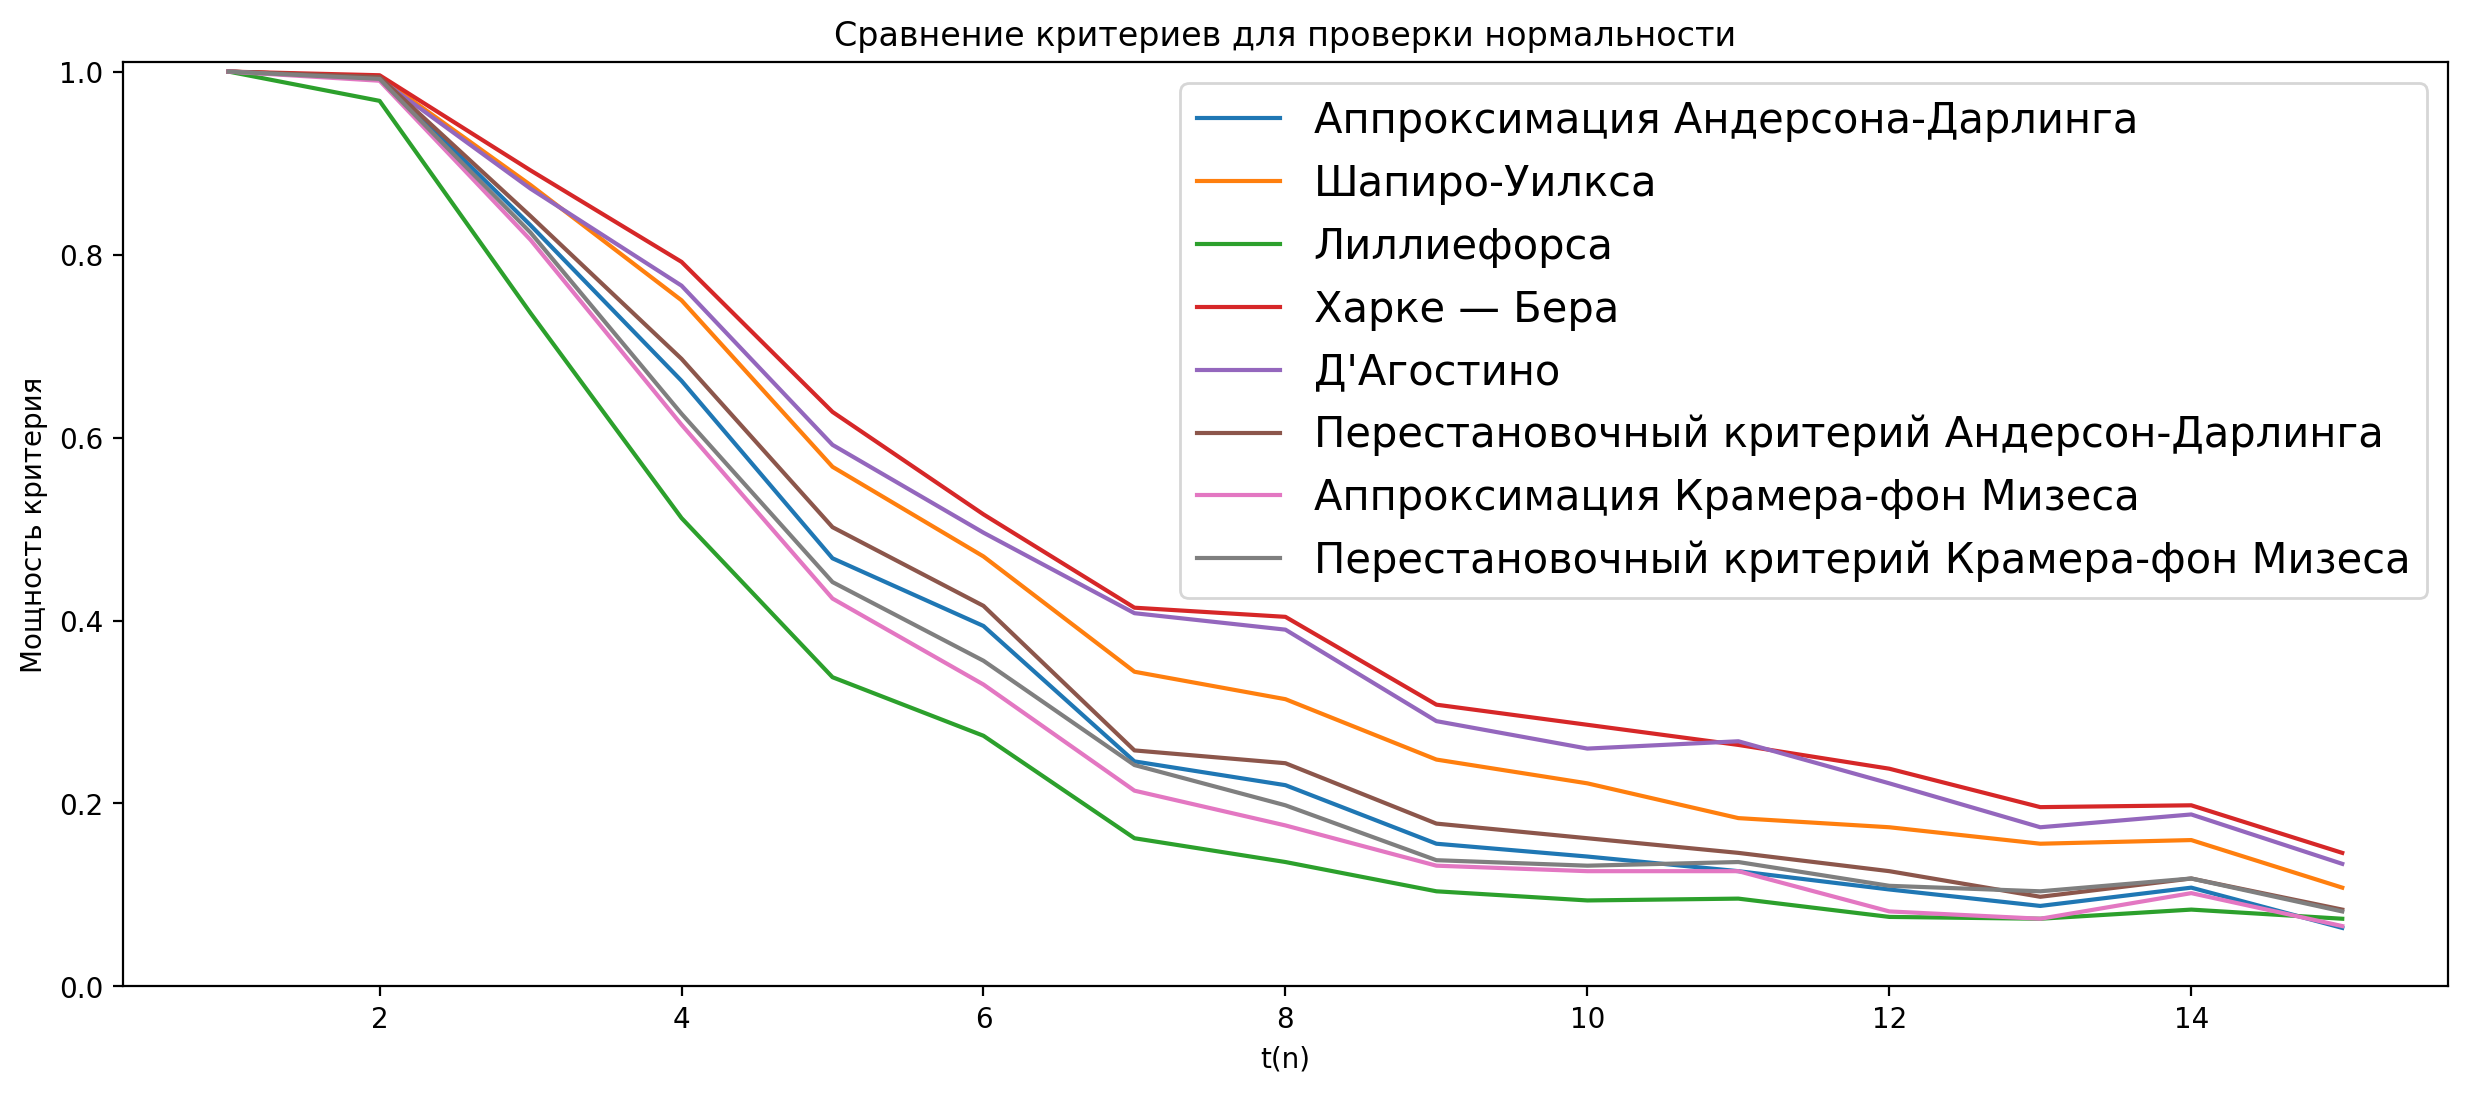

In [267]:
fig = plt.figure(figsize = (15,6))
plt.plot(x,y_1, label='Аппроксимация Андерсона-Дарлинга')
plt.plot(x,y_2, label='Шапиро-Уилкса')
plt.plot(x,y_3, label='Лиллиефорса')
plt.plot(x,y_4, label='Харке — Бера')
plt.plot(x,y_5, label="Д'Агостино")
plt.plot(x,y_6, label='Перестановочный критерий Андерсон-Дарлинга')
plt.plot(x,y_7, label='Аппроксимация Крамера-фон Мизеса')
plt.plot(x,y_8, label='Перестановочный критерий Крамера-фон Мизеса')
plt.xlabel("t(n)")
plt.ylim(0,1.01)
plt.ylabel("Мощность критерия")
plt.title("Сравнение критериев для проверки нормальности")
plt.legend(loc='upper right', prop={'size':15})
fig.set_facecolor('w')
fig.set_dpi(200)
fig.savefig(f'./Graphics/Normality_comparison.png', bbox_inches='tight')
plt.show()

## Exponentiality

In [241]:
def Perm_expon(X, method):
    '''
    Permutation method to genarate statistics distribution
    '''
    T_stat = method(X)
    N = 1000
    n = len(X)
    T = []
    X_new = expon.rvs(scale=np.mean(X), size=n*N).reshape(N,n)
    T = np.apply_along_axis(method, axis=0, arr=X_new)
    answ = np.mean(T>T_stat)
    return answ

In [260]:
from scipy.stats import shapiro, t, jarque_bera, normaltest, anderson, cramervonmises
from statsmodels.stats.diagnostic import lilliefors
x, y_1, y_2, y_3, y_4, y_5= [],[],[],[],[], []
alpha = 0.05
M = 200
SIZE = 100
N = 20
for n in range(N):
    x.append(n+1)
    p_value_AD_approx = []
    p_value_CVM_approx = []
    p_value_L = []
    p_value_AD = []
    p_value_CVM = []
    for m in range(M):
        Y = gamma.rvs(1+1/(n+1), scale=1, size = SIZE)
        CDF = lambda x: expon.cdf(x, scale=np.mean(Y))
        p_value_AD_approx.append(1 - AD_Pearson_approx[expon](stat_AD(Y, CDF)))
        p_value_CVM_approx.append(1 - CVM_Pearson_approx[expon](stat_CM(Y, CDF)))
        method = lambda x: stat_AD(x, CDF=lambda y: expon.cdf(y, scale=np.mean(x)))
        p_value_AD.append(Perm_expon(Y, method))
        method = lambda x: stat_CM(x, CDF=lambda y: expon.cdf(y, scale=np.mean(x)))
        p_value_CVM.append(Perm_expon(Y, method))
        p_value_L.append(lilliefors(Y,dist='exp')[1])
    y_1.append(sum(np.array(p_value_AD_approx) <= alpha)/M)
    y_2.append(sum(np.array(p_value_CVM_approx) <= alpha)/M)
    y_3.append(sum(np.array(p_value_L) <= alpha)/M)
    y_4.append(sum(np.array(p_value_AD) <= alpha)/M)
    y_5.append(sum(np.array(p_value_CVM) <= alpha)/M)


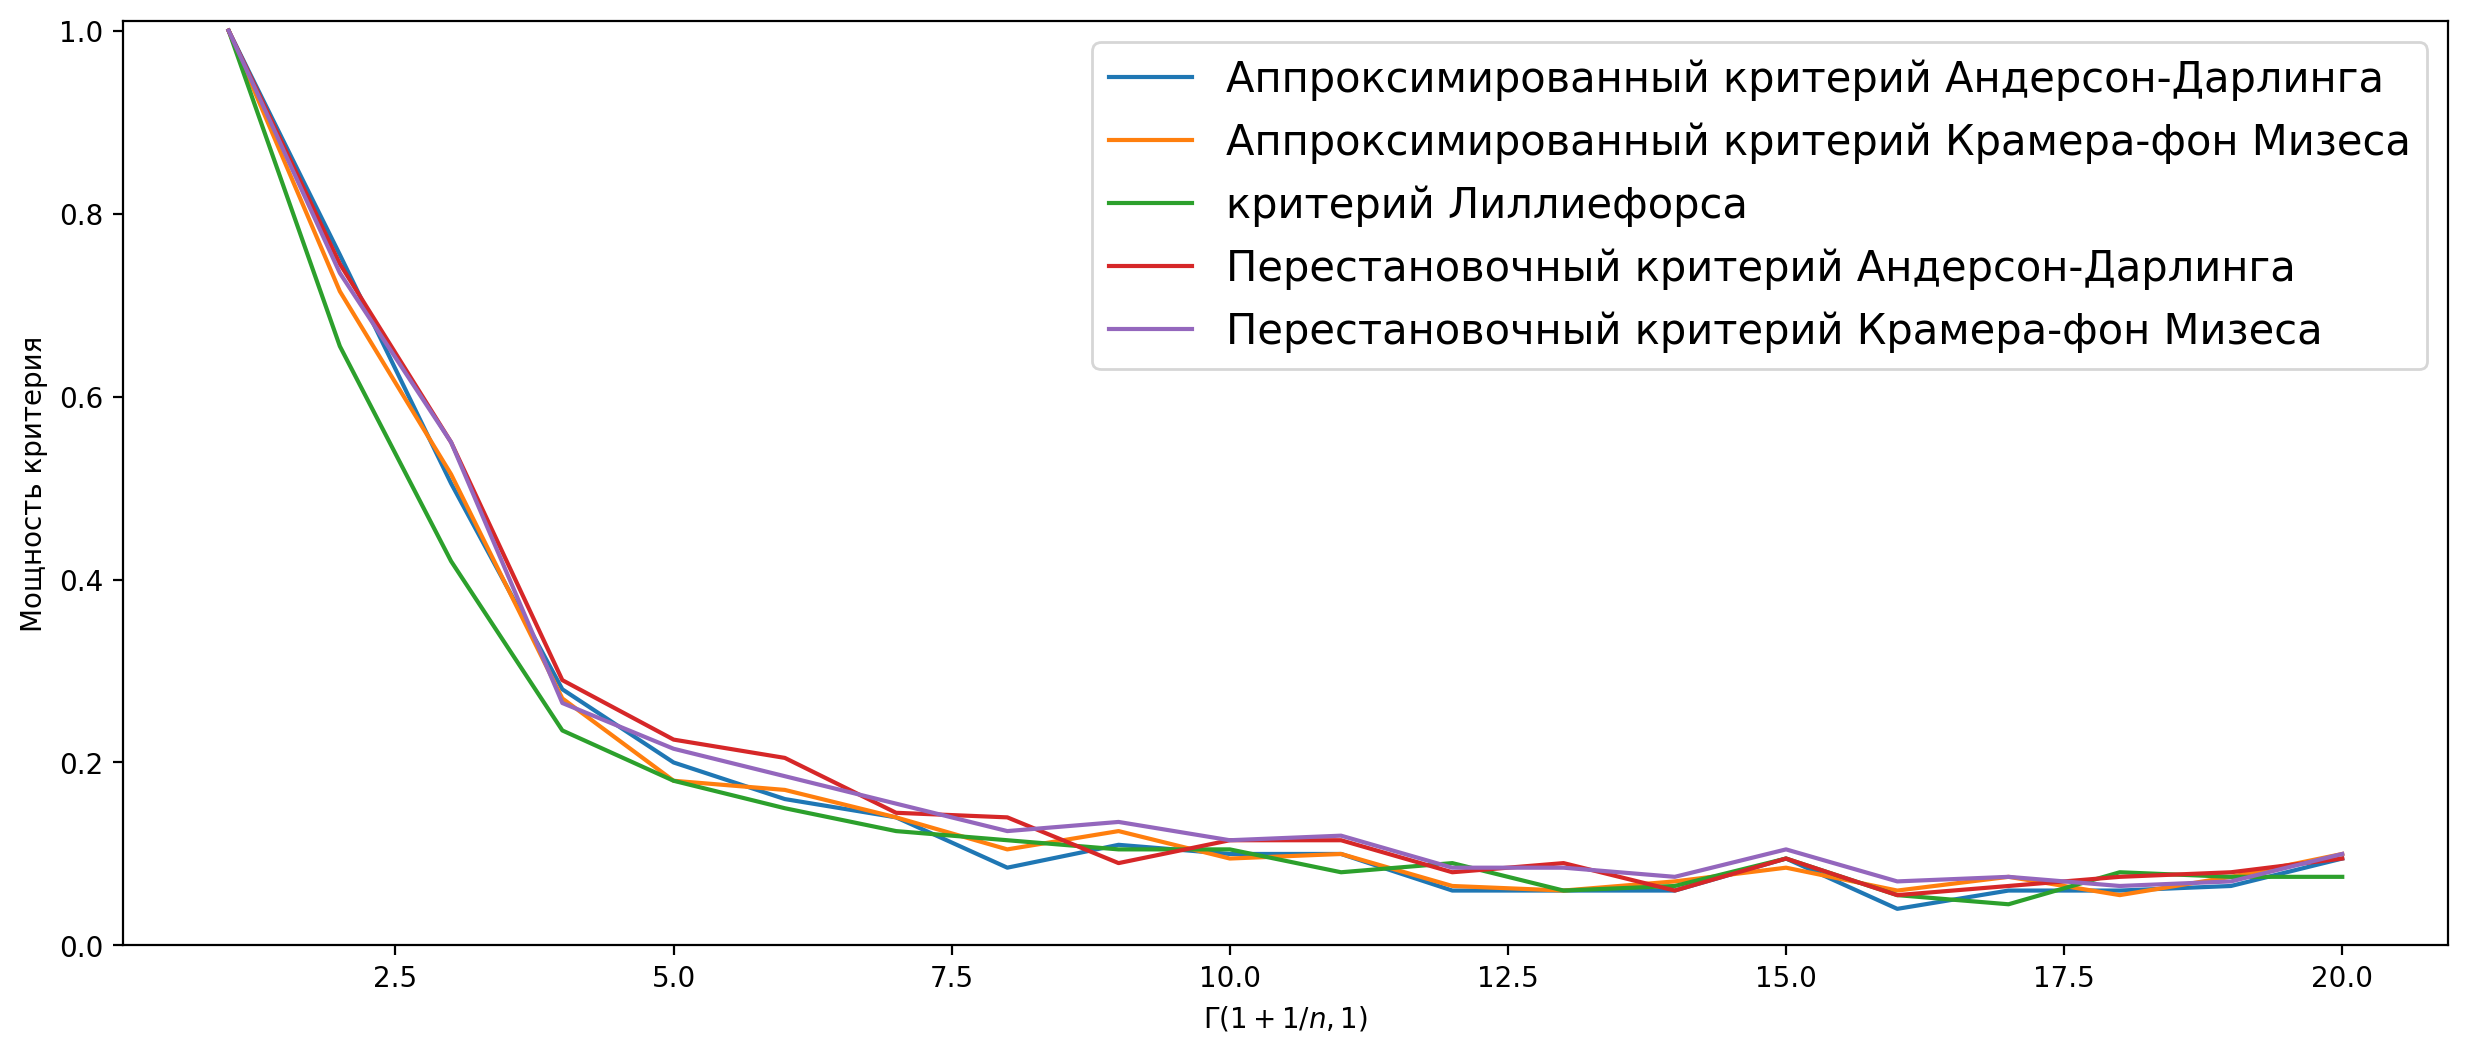

In [261]:
fig = plt.figure(figsize = (15,6))
plt.plot(x, y_1, label='Аппроксимированный критерий Андерсон-Дарлинга')
plt.plot(x, y_2, label='Аппроксимированный критерий Крамера-фон Мизеса')
plt.plot(x, y_3, label='критерий Лиллиефорса')
plt.plot(x, y_4, label='Перестановочный критерий Андерсон-Дарлинга')
plt.plot(x, y_5, label='Перестановочный критерий Крамера-фон Мизеса')
plt.xlabel("$\Gamma(1+1/n,1)$")
plt.ylim(0,1.01)
plt.ylabel("Мощность критерия")
plt.legend(loc='upper right', prop={'size':15})
fig.set_facecolor('w')
fig.set_dpi(200)
fig.savefig(f'./Graphics/Exponentiality_comparison.png', bbox_inches='tight')
plt.show()